In [1]:
#conda install -c conda-forge xarray dask netCDF4 bottleneck
#conda install -c conda-forge cfgrib
#conda install -c conda-forge geopandas
#conda install -c conda-forge rasterio
#pip install pyproj==2.6.1.post1
#pip install pyshp

In [2]:
import xarray as xr               #Leitura e manuseio de arquivos grib2 e nc.
import salem                      #Bib responsavel para fazer processamento e plotagem de dados geocientíficos.
import matplotlib.pyplot as plt   #Bib responsavel pelo Plot de gráficos.
import pandas as pd               #Bib responsavel pela criação de data frames.

In [3]:
data = xr.open_dataset('MERGE_CPTEC_20210901.grib2', engine='cfgrib') #Carregando os dados.
data

<xarray.Dataset>
Dimensions:     (latitude: 924, longitude: 1001)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 -60.05 -59.95 -59.85 ... 32.05 32.15 32.25
  * longitude   (longitude) float64 239.9 240.0 240.1 ... 339.8 339.9 340.0
    valid_time  datetime64[ns] ...
Data variables:
    prec        (latitude, longitude) float32 ...
    prmsl       (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             consensus
    GRIB_centreDescription:  Consensus
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Consensus
    history:                 2021-12-27T13:42 GRIB to CDM+CF via cfgrib-0.9.9...

In [4]:
data.to_netcdf('MERGE.nc')  #Salvando os dados e convertendo para o formato nc.

In [5]:
#Lendo o arquivo nc e convertendo as longitudes para variarem de -180 a 180° ao invés de 0 a 360°.
ds = salem.open_xr_dataset('MERGE.nc')                                   
ds.coords['longitude'] = ((ds.coords['longitude'] + 180) % 360) - 180    
ds = ds.sortby(ds.longitude)
ds

<xarray.Dataset>
Dimensions:     (latitude: 924, longitude: 1001)
Coordinates:
    time        datetime64[ns] ...
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 -60.05 -59.95 -59.85 ... 32.05 32.15 32.25
  * longitude   (longitude) float64 -120.1 -120.0 -119.9 ... -20.15 -20.05
    valid_time  datetime64[ns] ...
Data variables:
    prec        (latitude, longitude) float32 ...
    prmsl       (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             consensus
    GRIB_centreDescription:  Consensus
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Consensus
    history:                 2021-12-27T13:42 GRIB to CDM+CF via cfgrib-0.9.9...
    pyproj_srs:              +proj=longlat +datum=WGS84 +no_defs

In [6]:
#Abrindo o arquivo Shapefile.
shp = salem.read_shapefile('tiete.shp')  
shp

,bacia,subbacia,psat,geometry,min_x,max_x,min_y,max_y
0,Tietê,Edgard de Souza,PSATESZ,"POLYGON ((-46.99325 -23.80211, -46.99701 -23.7...",-47.096497,-45.637390,-23.952393,-23.331787
1,Tietê,Barra Bonita,PSATBBO,"POLYGON ((-47.00098 -23.79340, -47.05328 -23.8...",-48.592590,-45.869202,-23.874817,-22.062317
2,Tietê,Ibitinga,PSATIBT,"POLYGON ((-48.30144 -21.61761, -48.30157 -21.6...",-49.536682,-47.688110,-22.791016,-21.617608
3,Tietê,Nova Avanhandava,PSATNAV,"POLYGON ((-48.32458 -21.62372, -48.32492 -21.6...",-50.343384,-48.287109,-22.081909,-20.695312


In [7]:
#Recortando o arquivo original e usando o shapefile. 
dsr = ds.salem.roi(shape=shp).sel(latitude=slice(-25, -20), longitude=slice(-52, -44))
dsr

<xarray.Dataset>
Dimensions:     (latitude: 50, longitude: 80)
Coordinates:
    time        datetime64[ns] 2021-09-01T12:00:00
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
  * latitude    (latitude) float64 -24.95 -24.85 -24.75 ... -20.25 -20.15 -20.05
  * longitude   (longitude) float64 -51.95 -51.85 -51.75 ... -44.15 -44.05
    valid_time  datetime64[ns] 2021-09-01T12:00:00
Data variables:
    prec        (latitude, longitude) float32 nan nan nan nan ... nan nan nan
    prmsl       (latitude, longitude) float32 nan nan nan nan ... nan nan nan
Attributes:
    GRIB_edition:            2
    GRIB_centre:             consensus
    GRIB_centreDescription:  Consensus
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Consensus
    history:                 2021-12-27T13:42 GRIB to CDM+CF via cfgrib-0.9.9...
    pyproj_srs:              +proj=longlat +datum=WGS84 +no_defs

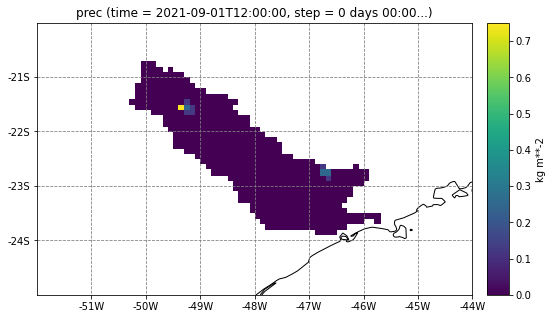

In [8]:
fig = plt.figure(figsize=(15, 5)) #Editando o tamanho do mapa.
dsr.prec.salem.quick_map()


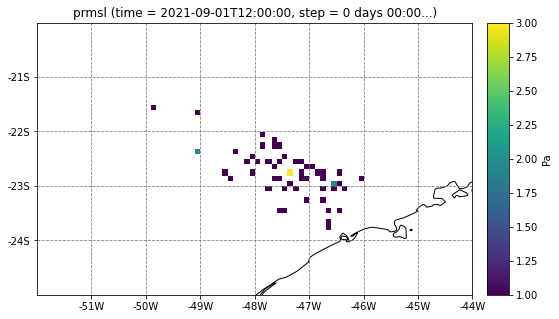

In [9]:
fig = plt.figure(figsize=(15, 5)) #Editando o tamanho do mapa.
dsr.prmsl.salem.quick_map();


In [10]:
df = pd.DataFrame(dsr.data_vars['prmsl'].values)  #Criando um DataFrame.
df = df.set_index(dsr.coords['latitude'].values)  #Trocandoo index como as coors. de latitude.
df.columns = dsr.coords['longitude'].values       #Trocando o nome das colunas para as coords. de longitude.
df                                                #Lendo os arquivos de ponto de grade.

,-51.95,-51.85,-51.75,-51.65,-51.55,-51.45,-51.35,-51.25,-51.15,-51.05,...,-44.95,-44.85,-44.75,-44.65,-44.55,-44.45,-44.35,-44.25,-44.15,-44.05
-24.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-24.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-24.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-24.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-24.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-24.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-24.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-24.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-24.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-24.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df_prec = pd.DataFrame(dsr.prec.values)               #Criando um DataFrame.
df_prec = df.set_index(dsr.coords['latitude'].values) #Trocandoo index como as coors. de latitude.
df_prec.columns = dsr.coords['longitude'].values      #Trocando o nome das colunas para as coords. de longitude.
df_prec                                               #Lendo os arquivos de ponto de grade.

,-51.95,-51.85,-51.75,-51.65,-51.55,-51.45,-51.35,-51.25,-51.15,-51.05,...,-44.95,-44.85,-44.75,-44.65,-44.55,-44.45,-44.35,-44.25,-44.15,-44.05
-24.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-24.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-24.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-24.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-24.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-24.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-24.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-24.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-24.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-24.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
dsl = dsr.salem.lookup_transform(ds)  #Por padrão o method utilizado é o 'np.mean'.
dsl

<xarray.Dataset>
Dimensions:     (longitude: 80, latitude: 50)
Coordinates:
    time        datetime64[ns] 2021-09-01T12:00:00
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
    valid_time  datetime64[ns] 2021-09-01T12:00:00
  * longitude   (longitude) float64 -51.95 -51.85 -51.75 ... -44.15 -44.05
  * latitude    (latitude) float64 -24.95 -24.85 -24.75 ... -20.25 -20.15 -20.05
Data variables:
    prec        (latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.375 0.125
    prmsl       (latitude, longitude) float32 nan nan nan nan ... nan nan 1.0
Attributes:
    pyproj_srs:  +proj=longlat +datum=WGS84 +no_defs

In [13]:
#Salvando o arquivo reduzido em um novo nc.
dsl.to_netcdf('resolucao_reduzida.nc')